# SAM 3 Cross-Image Few-Shot Detection

本筆記本演示如何使用 SAM 3 實現 Cross-Image Few-Shot Detection。
我們將從一張「Support Image」中提取 Bounding Box 的特徵作為 Visual Prompt，然後用這個 Visual Prompt 在「Query Image」中檢測相似的物體。

In [1]:
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import sam3
from sam3 import build_sam3_image_model
from sam3.model.box_ops import box_xywh_to_cxcywh, box_cxcywh_to_xyxy
from sam3.model.sam3_image_processor import Sam3Processor
from sam3.visualization_utils import draw_box_on_image, plot_results
from sam3.model.data_misc import interpolate

# 確保使用了正確的 sam3 環境
sam3_root = os.path.join(os.path.dirname(sam3.__file__), "..")

# 設定 GPU 加速
torch.backends.cuda.matmul.allow_tf32 = True
torch.backends.cudnn.allow_tf32 = True
torch.autocast("cuda", dtype=torch.bfloat16).__enter__()

E:\Research\SAM3_research\sam3\model_builder.py:8: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources
c:\Users\s5965\anaconda3\envs\sam3\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 1. 載入模型 (Load Model)

In [2]:
bpe_path = f"{sam3_root}/assets/bpe_simple_vocab_16e6.txt.gz"
# 請確保 checkpoint 路徑正確
checkpoint_path = "../sam3.pt"

try:
    model = build_sam3_image_model(checkpoint_path=checkpoint_path, bpe_path=bpe_path)
    print("模型載入成功！")
except Exception as e:
    print(f"模型載入失敗: {e}")
    print("請確保 'sam3.pt' 存在於上層目錄或指定正確路徑。")

processor = Sam3Processor(model, confidence_threshold=0.4)

模型載入成功！


## 2. 定義輔助函式 (Helper Functions)

由於 `Sam3Processor` 預設不直接支援 Cross-Image Prompting，我們需要定義兩個函式：
1. `extract_visual_prompt_embedding`: 從 Support Image 的 BBox 提取特徵。
2. `grounding_with_visual_prompt`: 將提取的特徵注入到 Query Image 的推論過程中。

In [13]:
@torch.inference_mode()
def extract_visual_prompt_embedding(processor, image, box):
    """
    從 Support Image 的 BBox 提取 Visual Prompt Embedding。
    
    Args:
        processor: Sam3Processor 實例
        image: PIL Image, Support Image
        box: List [x, y, w, h], Bounding Box
    
    Returns:
        visual_prompt_embed: 提取出的特徵 Tensor
    """
    # 設定圖片
    state = processor.set_image(image)
    
    # 正規化 BBox (x, y, w, h) -> (cx, cy, w, h) normalized
    width, height = image.size
    box_val = torch.tensor(box, dtype=torch.float32).view(-1, 4)
    box_cxcywh = box_xywh_to_cxcywh(box_val)
    box_cxcywh_norm = box_cxcywh / torch.tensor([width, height, width, height])
    
    # 加入幾何提示 (Geometric Prompt)
    # 這裡我們只執行到 _encode_prompt 的部分邏輯來獲取特徵，或者利用 model 的內部方法
    # 為了簡便，我們模擬 add_geometric_prompt 的前置步驟，然後手動呼叫 model._encode_prompt
    
    if "language_features" not in state["backbone_out"]:
        # 需要一個 dummy text prompt 讓模型運作
        dummy_text_outputs = processor.model.backbone.forward_text(["visual"], device=processor.device)
        state["backbone_out"].update(dummy_text_outputs)
        
    if "geometric_prompt" not in state:
        state["geometric_prompt"] = processor.model._get_dummy_prompt()
        
    # 加入 Box Prompt
    boxes = box_cxcywh_norm.to(processor.device).view(1, 1, 4)
    labels = torch.tensor([True], device=processor.device, dtype=torch.bool).view(1, 1)
    state["geometric_prompt"].append_boxes(boxes, labels)
    
    # 手動執行 _encode_prompt 來獲取 features
    # 我們需要 model._encode_prompt 產生的 geo_feats
    # 參考 sam3_image.py 的 _encode_prompt 實作
    
    find_input = processor.find_stage
    geometric_prompt = state["geometric_prompt"]
    backbone_out = state["backbone_out"]
    
    # 取得影像特徵
    feat_tuple = processor.model._get_img_feats(backbone_out, find_input.img_ids)
    _, img_feats, img_pos_embeds, vis_feat_sizes = feat_tuple
    
    # 編碼幾何提示 (Encode geometry)
    geo_feats, geo_masks = processor.model.geometry_encoder(
        geo_prompt=geometric_prompt,
        img_feats=img_feats,
        img_sizes=vis_feat_sizes,
        img_pos_embeds=img_pos_embeds,
    )
    
    # geo_feats 就是我們要的 visual prompt embedding
    # 形狀通常是 (N_tokens, Batch, Channel)
    return geo_feats, geo_masks

@torch.inference_mode()
def grounding_with_visual_prompt(processor, image, visual_prompt_embed, visual_prompt_mask, text_prompt="visual"):
    """
    使用 Visual Prompt 在 Query Image 上進行 Grounding。
    
    Args:
        processor: Sam3Processor 實例
        image: PIL Image, Query Image
        visual_prompt_embed: 來自 Support Image 的特徵
        visual_prompt_mask: 來自 Support Image 的遮罩
        text_prompt: 文字提示，通常設為 "visual" 表示使用視覺提示
    """
    # 設定 Query Image
    state = processor.set_image(image)
    
    # 設定 Text Prompt
    text_outputs = processor.model.backbone.forward_text([text_prompt], device=processor.device)
    state["backbone_out"].update(text_outputs)
    
    # 準備輸入
    if "geometric_prompt" not in state:
        state["geometric_prompt"] = processor.model._get_dummy_prompt()
        
    backbone_out = state["backbone_out"]
    find_input = processor.find_stage
    geometric_prompt = state["geometric_prompt"]
    
    # 手動執行 Forward Pass
    # 1. _encode_prompt (注入 visual_prompt_embed)
    prompt, prompt_mask, backbone_out = processor.model._encode_prompt(
        backbone_out,
        find_input,
        geometric_prompt,
        visual_prompt_embed=visual_prompt_embed,
        visual_prompt_mask=visual_prompt_mask
    )
    
    # 2. _run_encoder
    backbone_out, encoder_out, _ = processor.model._run_encoder(
        backbone_out, find_input, prompt, prompt_mask
    )
    
    out = {
        "encoder_hidden_states": encoder_out["encoder_hidden_states"],
        "prev_encoder_out": {
            "encoder_out": encoder_out,
            "backbone_out": backbone_out,
        },
    }
    
    # 3. _run_decoder
    # 這裡需要注意 pos_embed 可能需要根據 query image 重新生成或從 encoder_out 獲取
    out, hs = processor.model._run_decoder(
        memory=out["encoder_hidden_states"],
        pos_embed=encoder_out["pos_embed"],
        src_mask=encoder_out["padding_mask"],
        out=out,
        prompt=prompt,
        prompt_mask=prompt_mask,
        encoder_out=encoder_out,
    )
    
    # 4. _run_segmentation_heads
    processor.model._run_segmentation_heads(
        out=out,
        backbone_out=backbone_out,
        img_ids=find_input.img_ids,
        vis_feat_sizes=encoder_out["vis_feat_sizes"],
        encoder_hidden_states=out["encoder_hidden_states"],
        prompt=prompt,
        prompt_mask=prompt_mask,
        hs=hs,
    )
    
    # 後處理 (Post-processing) - 參考 Sam3Processor._forward_grounding
    out_bbox = out["pred_boxes"]
    out_logits = out["pred_logits"]
    out_masks = out["pred_masks"]
    out_probs = out_logits.sigmoid()
    presence_score = out["presence_logit_dec"].sigmoid().unsqueeze(1)
    out_probs = (out_probs * presence_score).squeeze(-1)

    keep = out_probs > processor.confidence_threshold
    out_probs = out_probs[keep]
    out_masks = out_masks[keep]
    out_bbox = out_bbox[keep]

    # 轉換 BBox 格式 [cx, cy, w, h] -> [x0, y0, x1, y1]
    boxes = box_cxcywh_to_xyxy(out_bbox)

    img_h = state["original_height"]
    img_w = state["original_width"]
    scale_fct = torch.tensor([img_w, img_h, img_w, img_h]).to(processor.device)
    boxes = boxes * scale_fct[None, :]

    out_masks = interpolate(
        out_masks.unsqueeze(1),
        (img_h, img_w),
        mode="bilinear",
        align_corners=False,
    ).sigmoid()

    state["masks_logits"] = out_masks.detach()
    state["masks"] = (out_masks > 0.5).detach()
    state["boxes"] = boxes.detach()
    state["scores"] = out_probs.detach()
    return state

@torch.inference_mode()
def extract_dense_features(processor, image):
    """
    從影像中提取 dense feature map。
    """
    state = processor.set_image(image)
    # 取最後一層的 feature map, shape: (1, C, H, W)
    # 這裡假設 vis_feats 是 list，取最後一個元素
    backbone_out = state["backbone_out"]
    
    # 根據 Sam3Image._get_img_feats 邏輯獲取 features
    # 我們需要手動執行一下獲取 vis_feats 的部分
    # 因為 processor.set_image 已經跑過了 backbone.forward_image
    
    # NOTE: 這裡我們簡單地從 backbone_out["backbone_fpn"] 取值
    # 注意: backbone_fpn 包含多層 features，我們取最後一層 (最高語意層)
    vis_feats = backbone_out["backbone_fpn"][-1] 
    
    return vis_feats

def compute_pca_visualization(features):
    """
    計算 Feature Map 的 PCA 可視化。
    
    Args:
        features: Tensor (1, C, H, W)
        
    Returns:
        pca_image: Numpy array (H, W, 3), RGB reduced features
    """
    # 確保使用 Float32 進行 PCA 計算，並暫時關閉 Autocast 以避免內部矩陣運算轉回 BFloat16
    # 這解決了 "geqrf_cuda" not implemented for 'BFloat16' 錯誤
    with torch.autocast("cuda", enabled=False):
        features = features.float()
        
        # Reshape: (1, C, H, W) -> (H*W, C)
        B, C, H, W = features.shape
        features_flat = features.permute(0, 2, 3, 1).reshape(-1, C)
        
        # Normalize features
        features_flat = torch.nn.functional.normalize(features_flat, p=2, dim=1)
        
        # PCA using torch.pca_lowrank
        # 這裡我們取前 3 個主成分映射到 RGB
        U, S, V = torch.pca_lowrank(features_flat, q=3, center=True, niter=2)
        
        # Project data: (H*W, C) @ (C, 3) -> (H*W, 3)
        pca_features = torch.matmul(features_flat, V[:, :3])
        
        # Min-Max Normalize to [0, 1] for visualization
        pca_features = (pca_features - pca_features.min(dim=0)[0]) / (pca_features.max(dim=0)[0] - pca_features.min(dim=0)[0] + 1e-6)
        
        # Reshape back to image: (H, W, 3)
        pca_image = pca_features.reshape(H, W, 3).cpu().numpy()
        return pca_image

def compute_correlation_map(feature_map, prompt_embedding):
    """
    計算 Prompt Embedding 與 Feature Map 的 Cosine Similarity。
    
    Args:
        feature_map: Tensor (1, C, H, W)
        prompt_embedding: Tensor (N, 1, C) or (C,) - Visual Prompt Embedding
        
    Returns:
        correlation_map: Numpy array (H, W)
    """
    # 處理 prompt_embedding 形狀
    # extract_visual_prompt_embedding 返回的是 (N_tokens, Batch, C)
    # 我們取平均作為代表向量 -> (1, 1, C) -> (1, C, 1, 1)
    if prompt_embedding.dim() == 3:
        prompt_vec = prompt_embedding.mean(dim=0).mean(dim=0) # (C,)
    else:
        prompt_vec = prompt_embedding.reshape(-1)
        
    prompt_vec = prompt_vec.view(1, -1, 1, 1) # (1, C, 1, 1)
    
    # Normalize
    feature_map_norm = torch.nn.functional.normalize(feature_map, p=2, dim=1)
    prompt_vec_norm = torch.nn.functional.normalize(prompt_vec, p=2, dim=1)
    
    # # Cosine Similarity: sum(A * B) over channel dim
    sim_map = (feature_map_norm * prompt_vec_norm).sum(dim=1) # (1, H, W)
    
    return sim_map.squeeze().cpu().numpy()

## 3. 執行 Few-Shot Detection

### 3.1 準備圖片
請在下方指定 Support Image 和 Query Image 的路徑，以及 Support Image 上的 BBox。

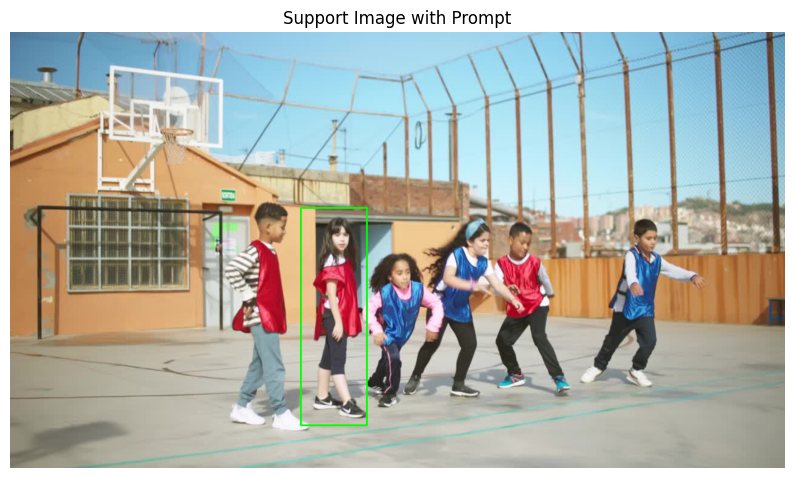

In [14]:
# 範例圖片 (請替換為實際圖片路徑)
# 這裡假設 assets/images/test_image.jpg 存在，我們用同一張圖做測試，但邏輯是通用的
support_image_path = f"{sam3_root}/assets/images/test_image.jpg"
query_image_path = f"{sam3_root}/assets/videos/0001/0.jpg" # 實際應用中通常是不同圖片

if not os.path.exists(support_image_path):
    print(f"Warning: {support_image_path} not found. Please set correct image path.")
else:
    support_img = Image.open(support_image_path).convert("RGB")
    query_img = Image.open(query_image_path).convert("RGB")
    
    # 定義 Support Box (x, y, w, h)
    # 這裡需要使用者根據圖片內容指定一個 BBox
    # 例如：選擇第一隻鞋子
    support_box = [480.0, 290.0, 110.0, 360.0] # [x, y, w, h]
    
    # 顯示 Support Image 和 BBox
    plt.figure(figsize=(10, 10))
    plt.imshow(draw_box_on_image(support_img, support_box))
    plt.title("Support Image with Prompt")
    plt.axis("off")
    plt.show()

### 3.2 提取 Visual Prompt並推論

提取 Visual Prompt 特徵...
特徵提取完成，形狀: torch.Size([2, 1, 256])
在 Query Image 上進行推論...
檢測到 4 個物體
found 4 object(s)


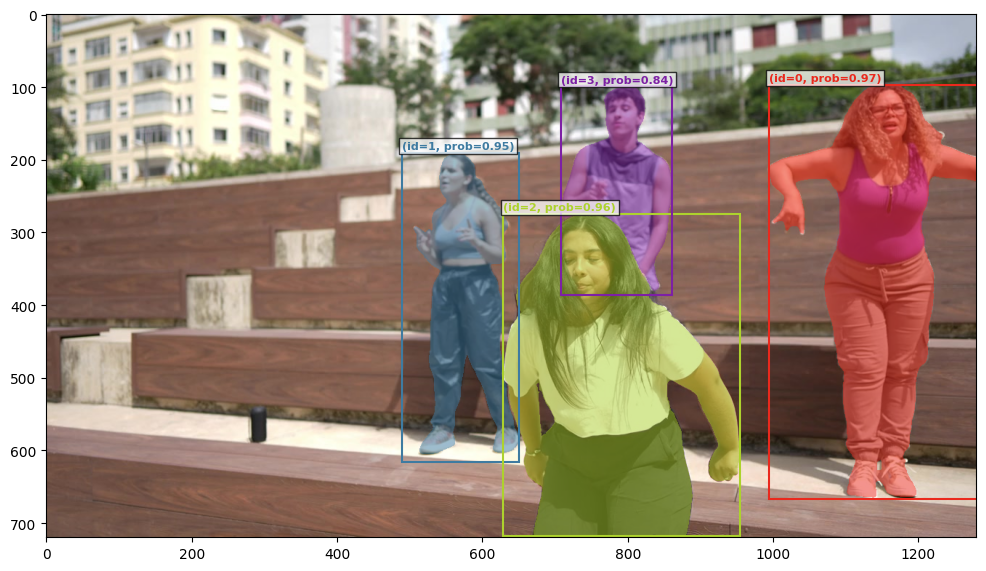

In [18]:
if 'support_img' in locals() and 'query_img' in locals():
    print("提取 Visual Prompt 特徵...")
    # 1. 提取特徵
    vis_embed, vis_mask = extract_visual_prompt_embedding(processor, support_img, support_box)
    print(f"特徵提取完成，形狀: {vis_embed.shape}")
    
    print("在 Query Image 上進行推論...")
    # 2. 推論
    result_state = grounding_with_visual_prompt(processor, query_img, vis_embed, vis_mask)
    
    # 3. 顯示結果
    print(f"檢測到 {len(result_state['scores'])} 個物體")
    plot_results(query_img, result_state)
else:
    print("請先載入圖片")

### 3.3 可解釋性分析 (Interpretability Analysis)

這部分將展示：
1. **PCA Feature Visualization**: 將高維特徵投影到 RGB 空間，顯示圖片的語意分佈。
2. **Attention/Correlation Map**: 顯示 Support Box 特徵與 Support/Query Image 的相似度關聯。

計算特徵與關聯性...


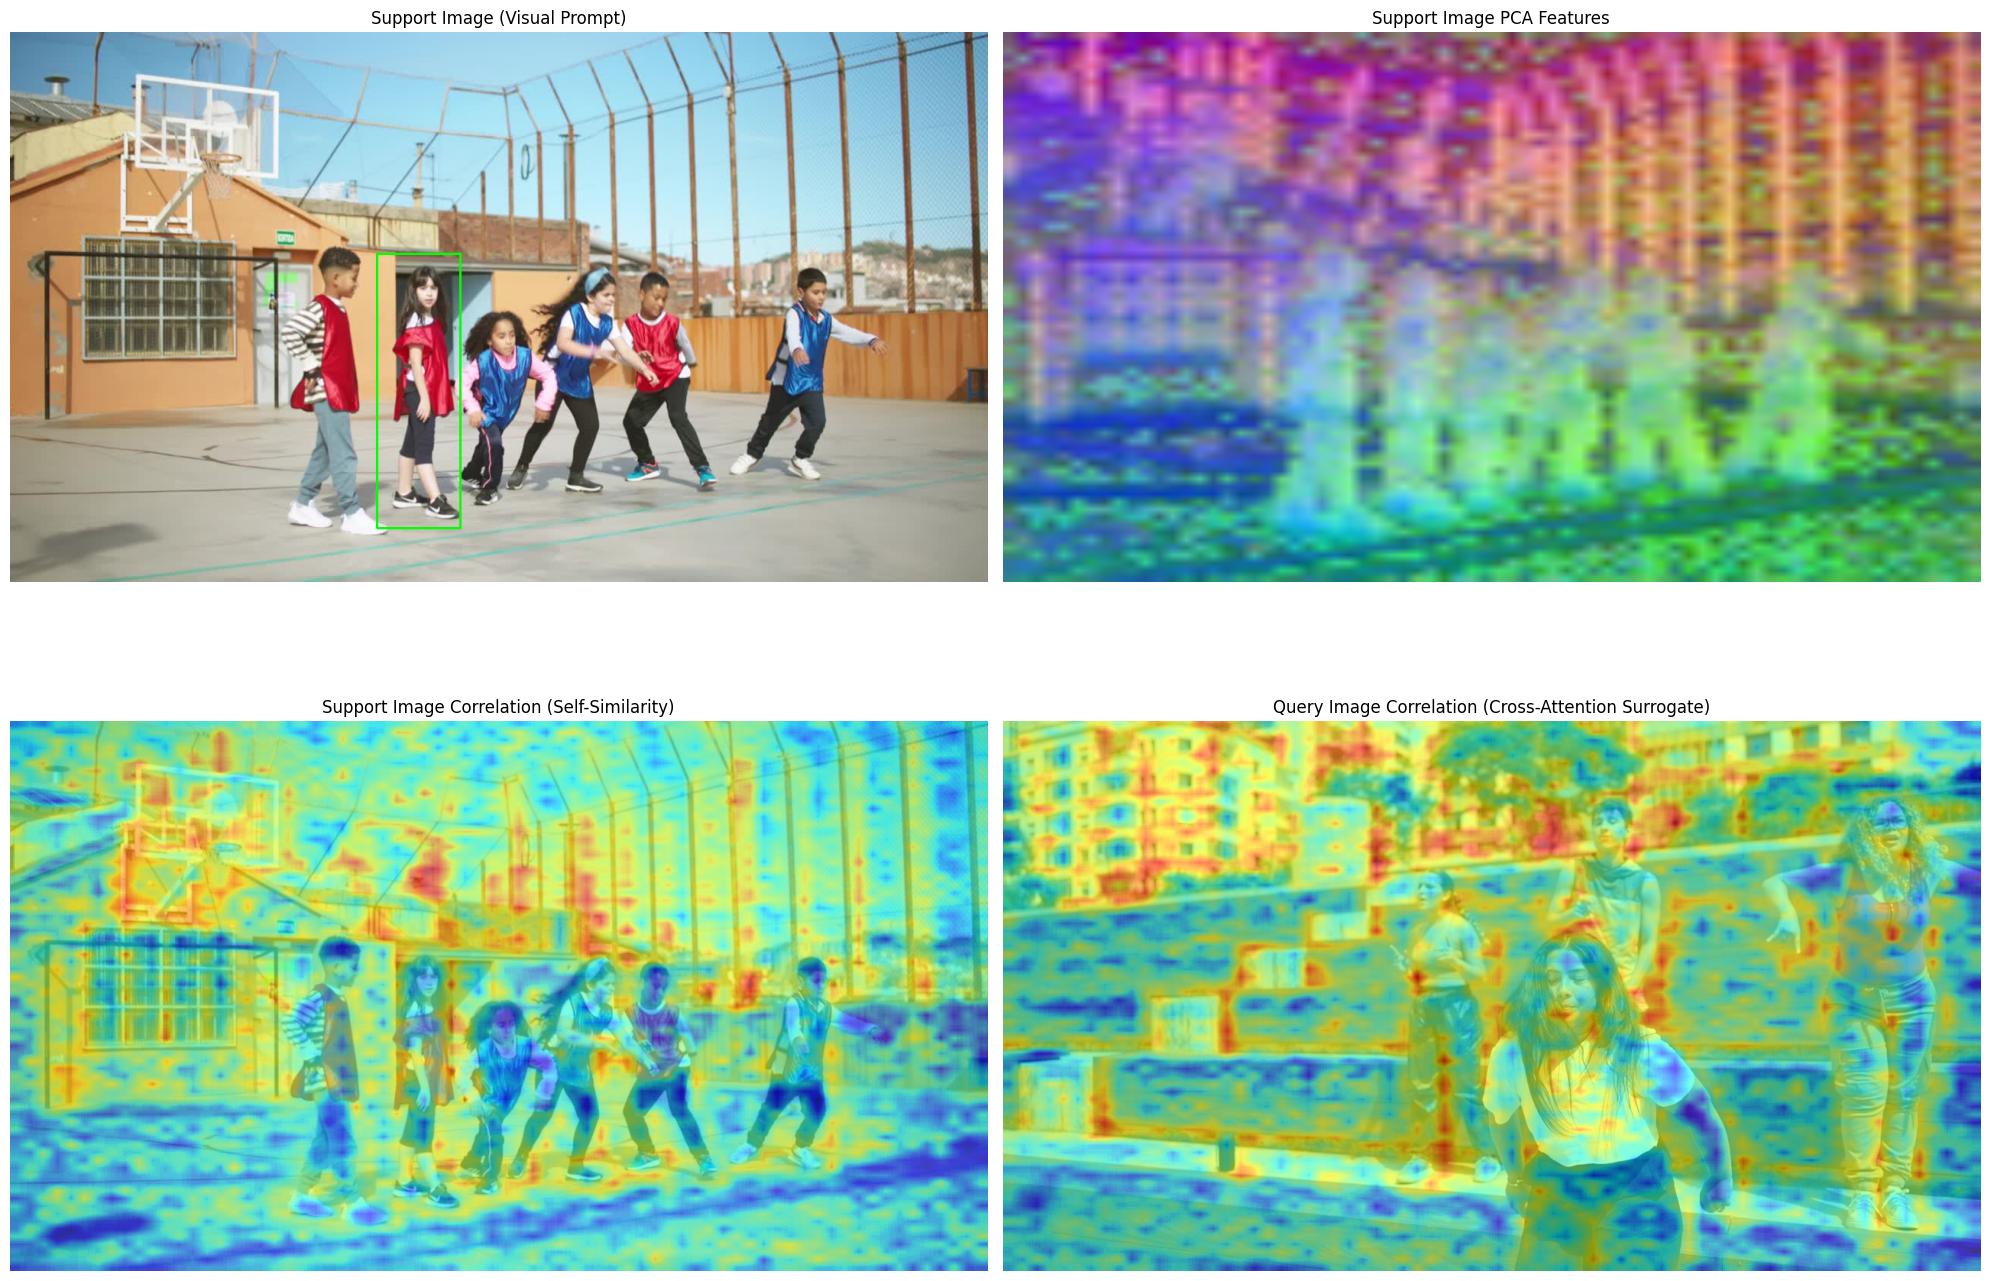

In [19]:
if 'support_img' in locals() and 'query_img' in locals() and 'vis_embed' in locals():
    print("計算特徵與關聯性...")
    
    # 1. 提取 Dense Features
    support_feats = extract_dense_features(processor, support_img)
    query_feats = extract_dense_features(processor, query_img)
    
    # 2. PCA Visualization (Support Image)
    pca_vis = compute_pca_visualization(support_feats.float())
    pca_vis = np.array(Image.fromarray((pca_vis * 255).astype(np.uint8)).resize(support_img.size, resample=Image.BILINEAR))
    
    # 3. Correlation Map (Support Box vs Support Image)
    corr_support = compute_correlation_map(support_feats, vis_embed)
    corr_support = np.array(Image.fromarray(((corr_support + 1) / 2 * 255).astype(np.uint8)).resize(support_img.size, resample=Image.BILINEAR))
    
    # 4. Correlation Map (Support Box vs Query Image)
    corr_query = compute_correlation_map(query_feats, vis_embed)
    corr_query = np.array(Image.fromarray(((corr_query + 1) / 2 * 255).astype(np.uint8)).resize(query_img.size, resample=Image.BILINEAR))
    
    # 5. 顯示結果
    fig, axes = plt.subplots(2, 2, figsize=(20, 15))
    
    # Support Image
    axes[0, 0].imshow(draw_box_on_image(support_img, support_box))
    axes[0, 0].set_title("Support Image (Visual Prompt)")
    axes[0, 0].axis('off')
    
    # PCA Features
    axes[0, 1].imshow(pca_vis)
    axes[0, 1].set_title("Support Image PCA Features")
    axes[0, 1].axis('off')
    
    # Support Correlation
    axes[1, 0].imshow(support_img)
    axes[1, 0].imshow(corr_support, alpha=0.6, cmap='jet')
    axes[1, 0].set_title("Support Image Correlation (Self-Similarity)")
    axes[1, 0].axis('off')
    
    # Query Correlation
    axes[1, 1].imshow(query_img)
    axes[1, 1].imshow(corr_query, alpha=0.6, cmap='jet')
    axes[1, 1].set_title("Query Image Correlation (Cross-Attention Surrogate)")
    axes[1, 1].axis('off')
    
    plt.tight_layout()
    plt.show()
else:
    print("請先執行前面的步驟")

### 3.4 進階可解釋性分析 (Advanced Interpretability Analysis)

此部分計算並可視化：
1.  **Support BBox Features vs. Support Image**: 顯示 Support BBox 區域特徵與 Support Image 其他區域的關聯性。
2.  **Support BBox Features vs. Query Image**: 顯示 Support BBox 區域特徵與 Query Image 各區域的關聯性。

正在提取 Support Image 特徵...
正在提取 Query Image 特徵...
計算關聯性 (Cosine Similarity)...


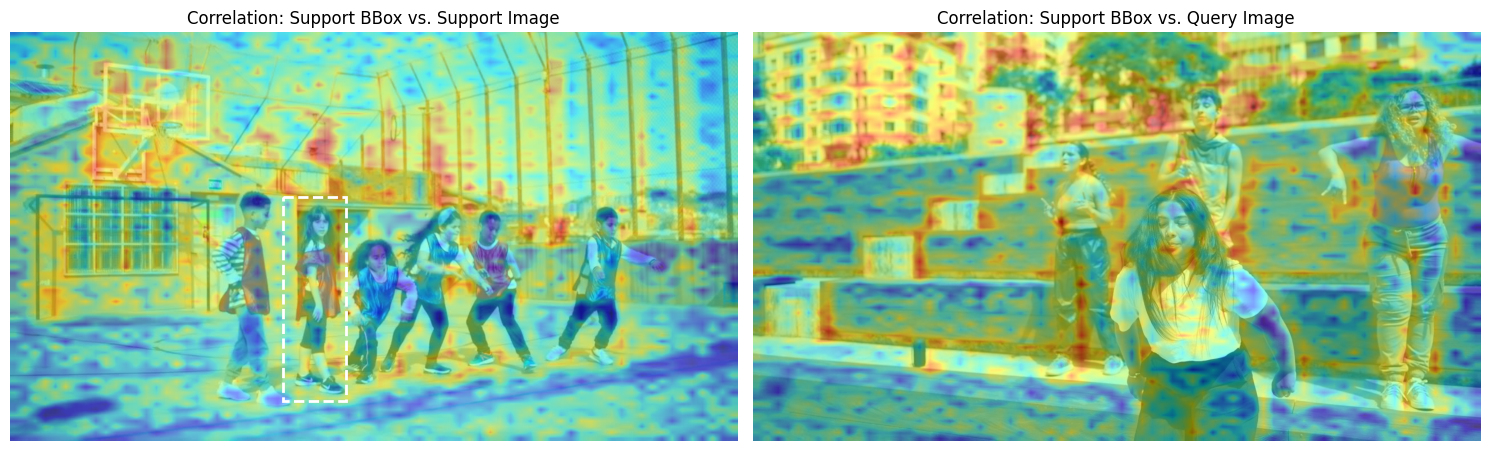

In [27]:
# 確保變數存在 (假設 3.1 & 3.2 已經執行)
if 'processor' in locals() and 'support_img' in locals() and 'query_img' in locals() and 'vis_embed' in locals():
    
    print("正在提取 Support Image 特徵...")
    support_feats = extract_dense_features(processor, support_img)
    
    print("正在提取 Query Image 特徵...")
    query_feats = extract_dense_features(processor, query_img)
    
    print("計算關聯性 (Cosine Similarity)...")
    # 1. Support BBox Embedding vs Support Image Features
    sim_support = compute_correlation_map(support_feats, vis_embed)
    
    # 2. Support BBox Embedding vs Query Image Features
    sim_query = compute_correlation_map(query_feats, vis_embed)
    
    # --- Visualization ---
    plt.figure(figsize=(15, 6))

    # Plot 1: Support Image Correlation
    plt.subplot(1, 2, 1)
    # Resize similarity map to match image size
    sim_support_resized = np.array(Image.fromarray(sim_support).resize(support_img.size, resample=Image.BILINEAR))
    
    plt.imshow(support_img)
    # Overlay heatmap
    plt.imshow(sim_support_resized, cmap='jet', alpha=0.5)
    # Draw the support bbox for reference
    # support_box is [x, y, w, h]
    if 'support_box' in locals():
        x, y, w, h = support_box
        rect = plt.Rectangle((x, y), w, h, linewidth=2, edgecolor='white', facecolor='none', linestyle='--')
        plt.gca().add_patch(rect)
        
    plt.title("Correlation: Support BBox vs. Support Image")
    plt.axis('off')

    # Plot 2: Query Image Correlation
    plt.subplot(1, 2, 2)
    # Resize similarity map to match image size
    sim_query_resized = np.array(Image.fromarray(sim_query).resize(query_img.size, resample=Image.BILINEAR))
    
    plt.imshow(query_img)
    plt.imshow(sim_query_resized, cmap='jet', alpha=0.5)
    plt.title("Correlation: Support BBox vs. Query Image")
    plt.axis('off')

    plt.tight_layout()
    plt.show()
else:
    print("請先執行前面的 Cell 以載入圖片與模型，並提取 visual_prompt_embed。")

In [ ]:
print('processor' in locals() and 'support_image' in locals())

False


### 4. 技術深度解析：為什麼要手動呼叫模型內部方法？ (Technical Deep Dive)

在標準的 `model.forward_grounding` 流程中，`_encode_prompt`、`_run_encoder` 和 `_run_decoder` 是依序被呼叫的。但在 Cross-Image Few-Shot Detection 的情境下，我們需要**手動拆解**這三個步驟，理由是標準的 `forward_grounding` 方法**沒有開放接口讓我們注入外部的 `visual_prompt_embed` (來自 Support Image 的特徵)**。

以下是這三個方法的詳細差異與在此任務中的角色：

#### 1. `processor.model._encode_prompt` (提示編碼)

*   **功能**: 這是「準備階段」。它的工作是收集所有的提示 (Prompts)，包括文字 (Text)、幾何圖形 (Box/Point)，以及我們最在意的 **Visual Prompt (影像特徵)**，並將它們轉換成 Transformer Encoder 可以理解的統一格式。
*   **本任務的關鍵作用**:
    *   這一步是我們「注入」Support Image 特徵的入口。
    *   原本的 `forward_grounding` 函式內部呼叫此方法時，`visual_prompt_embed` 預設是 `None`。
    *   我們手動呼叫它，就是為了把從 Support Image 提取出來的 `visual_prompt_embed` 傳進去，讓它與 Query Image 的 Box/Text prompts 串接在一起。
*   **輸入**: Backbone 特徵 (`backbone_out`)、幾何提示 (`geometric_prompt`)、**視覺提示 (`visual_prompt_embed`)**。
*   **輸出**: 整合後的 `prompt` embedding (包含文字、Box、視覺特徵) 和對應的 `prompt_mask`。

#### 2. `processor.model._run_encoder` (執行編碼器)

*   **功能**: 這是「特徵融合階段」。它執行 **Transformer Encoder**。
*   **運作方式**:
    *   它接收 Query Image 的原始特徵 (來自 CNN/ViT Backbone)。
    *   它接收上一步 (`_encode_prompt`) 產生的整合提示 (`prompt`)。
    *   透過 Self-Attention 和 Cross-Attention 機制，讓 Query Image 的特徵與 Prompt 特徵進行互動。例如：模型會根據 Visual Prompt (鞋子的特徵) 去「關注」Query Image 中相似的區域。
*   **輸入**: Backbone 特徵、整合後的 Prompt。
*   **輸出**: `encoder_out`，其中包含編碼後的圖像特徵 (`encoder_hidden_states`，也稱為 Memory)。這是已經「理解」了提示內容的圖像特徵。

#### 3. `processor.model._run_decoder` (執行解碼器)

*   **功能**: 這是「結果生成階段」。它執行 **Transformer Decoder** 並產生最終預測。
*   **運作方式**:
    *   它使用一組可學習的 Queries (Object Queries)。
    *   它從 Encoder 輸出的 Memory 中檢索資訊。
    *   它最終通過預測頭 (Prediction Heads) 輸出 Bounding Boxes (`pred_boxes`) 和 類別分數 (`pred_logits`)。
*   **輸入**: Encoder 的輸出 (`memory`)。
*   **輸出**: `out` 字典，包含最終的 `pred_boxes` (預測框) 和 `pred_logits` (預測分數)。

#### 總結比較表

| 方法 | 階段 | 核心任務 | Cross-Image 任務中的角色 |
| :--- | :--- | :--- | :--- |
| **`_encode_prompt`** | **前處理** | 將 Box、Text、Visual 三種提示打包成統一的 `prompt` 向量。 | **關鍵注入點**：在此處將 Support Image 的特徵 (`visual_prompt_embed`) 塞入模型。 |
| **`_run_encoder`** | **特徵融合** | 讓 Query Image 特徵與 Prompt 向量進行 Attention 互動。 | **特徵對齊**：Query Image 開始「尋找」與 Support Image 特徵相似的區域。 |
| **`_run_decoder`** | **預測生成** | 根據 Encoder 的結果，解碼出具體的 Box 座標和信心分數。 | **結果輸出**：產出最終在 Query Image 上偵測到的物體位置。 |